#### Variaveis para mudar:

chunk_size (tamanho da linha, dependendo se for vertical ou horizontal muda)
<br>
save_model_name (nome do modelo)
<br>
orientation (vertical ou horizontal)

In [1]:
from inference_utils import extract_level_representation, fix_level_format, fix_level_format_extra
from create_img import convert_kidicarus_to_png, convert_loderunner_to_png, convert_mario_to_png, convert_rainbowisland_to_png

In [2]:
from unsloth import FastLanguageModel
import torch
import os
from huggingface_hub import login
from unsloth.chat_templates import get_chat_template
from datasets import load_dataset
from unsloth.chat_templates import standardize_sharegpt
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported
from unsloth.chat_templates import train_on_responses_only

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/pressprexx/miniconda3/envs/unsloth/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
save_model_name = "../models/mario/Llama-3.1-8B-Instruct-unsloth-bnb-4bit-mario-teste1"

In [4]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

if True:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = save_model_name, # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth 2025.4.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.677 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.4.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [5]:
messages = [
    {"role": "user", "content": "Create a level"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")


outputs = model.generate(input_ids = inputs, max_new_tokens = 4096, use_cache = True,
                         temperature = 1.0, min_p = 0.1)
response = tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [6]:
print(response[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Create a level<|eot_id|><|start_header_id|>assistant<|end_header_id|>

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
----------------------------------------XX-------
---------------------------------------XXX-------
--------------------------------------XXXX-------
-------------------------------------XXXXX-------
------------------------------------XXXXXX---S---
----------------E---------------E--XXXXXX-------
-------------------------------E--XXXXXXXX-------
-------------------------XXXXXXXXXXXXXXXXXXXXXXX
-------------------------XXXXXXXXXXXXXXXXXXXXXXX<|eot_id|>


In [7]:
level = extract_level_representation(response[0], model_type="llama-3", orientation="horizontal", separator="\n")

In [8]:
print(level)

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
----------------------------------------XX-------
---------------------------------------XXX-------
--------------------------------------XXXX-------
-------------------------------------XXXXX-------
------------------------------------XXXXXX---S---
----------------E---------------E--XXXXXX-------
-------------------------------E--XXXXXXXX-------
-------------------------XXXXXXXXXXXXXXXXXXXXXXX
-------------------------XXXXXXXXXXXXXXXXXXXXXXX


In [9]:
# Mario
fixed_level = fix_level_format_extra(level, empty_space='-', line_quantity=14, column_quantity=50, enforce_shape="both", add_ground="X")

# Loderunner
# fixed_level = fix_level_format_extra(level, empty_space='-', line_quantity=22, column_quantity=32, enforce_shape="both", add_ground="X")

# Kidicarus
# fixed_level = fix_level_format_extra(level, empty_space='-', line_quantity=20, column_quantity=16, enforce_shape="both", add_ground="X")

# Rainbow Island
# fixed_level = fix_level_format_extra(level, empty_space='-', line_quantity=35, column_quantity=32, enforce_shape="both", add_ground="X")

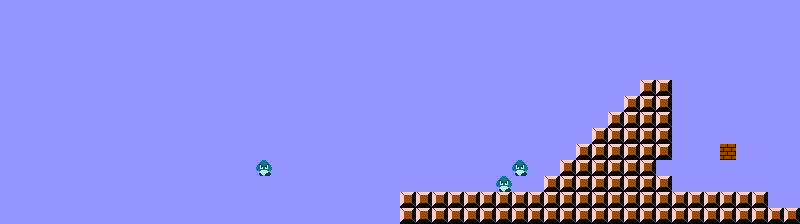

In [10]:
from IPython.display import display

# Call the function and extract the image
img, _, _ = convert_mario_to_png(fixed_level)

# Display the image in the notebook
display(img)

### Metrics

In [11]:
from metrics import SampledLevelEvaluator
from metrics import print_level_from_columns

def print_in_chunks(s, chunk_size=50):
    for i in range(0, len(s), chunk_size):
        print(s[i:i+chunk_size])

In [12]:
# Settings (Mude dependendo do seu modelo)

orientation = 'horizontal'

horizontal_var = "str_horizontal_nosplit"
vertical_var = "str_vertical_nosplit"

data_path = '../level_json/mario/mario1and2.json'
seperator = "\n"
level_to_evaluate = fixed_level

In [13]:
import json

sample_list = []
with open(data_path, 'r') as f:
    level_data = json.load(f)

print(level_data[-1]['window'])

for level in level_data:
    if orientation == 'horizontal':
        str_level = level[horizontal_var]
    else:
        str_level = level[vertical_var]
    sample_list.append(str_level)

print(sample_list[-1])

['--------------------------------------------------', '--------------------------------------------------', '--------------------------------------------------', '--------------------------------------------------', '--------------------------------------------------', '------------------------------------XX------------', '------------------------------------XX------------', '----------------------------------X-XX------------', '----------------------------------X-XX------------', '---------------E----------------X-X-XX------------', '--------------<>----------E-----X-X-XX------------', '--------------[]---------<>---X-X-X-XX------------', '-E------E-EE--[]---------[]---X-X-X-XX--------X---', 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXX-X-X-X-XXXXXXXXXXXXXX']
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
evaluation_level = level_to_evaluate.replace(seperator, '')
evaluator = SampledLevelEvaluator()

print(level_to_evaluate)

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
----------------------------------------XX--------
---------------------------------------XXX--------
--------------------------------------XXXX--------
-------------------------------------XXXXX--------
------------------------------------XXXXXX---S----
----------------E---------------E--XXXXXX---------
-------------------------------E--XXXXXXXX--------
-------------------------XXXXXXXXXXXXXXXXXXXXXXX--
-------------------------XXXXXXXXXXXXXXXXXXXXXXXXX


In [15]:
# ATENÇÃO - Verifique que as fases do dataset e a fase gerada são do mesmo tamanho

print(len(sample_list[0]))
print(len(sample_list[1]))
print(len(evaluation_level))

700
700
700


In [16]:
best_metrics = evaluator.evaluate_sample_on_dataset(sample_list, evaluation_level, metrics=["hamming_distance"])

Finding best metrics: 100%|██████████| 5609/5609 [00:00<00:00, 4122279.86it/s]


In [17]:
print(best_metrics)

{'hamming_distance': {'score': 40, 'level': '--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------XX-----------------------------------------------XXX----------------------------------------------XXXX---------------------------------------------XXXXX--------------------------------------------XXXXXX---S------------------X--------------------XXXXXXX----------------------X-------------------XXXXXXXX----------------------X------------------XXXXXXXXX----------XXX--XXXXXXXX--XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'}}


In [18]:
print("\nBest metrics on dataset windows:")

for metric, data in best_metrics.items():
    print(f'\n\n{"*"*100}\n')
    print(f"\n{metric} => Score: {data['score']}, Level: ")
    print_in_chunks(data['level'], chunk_size=50)
    print(f'\n Original Level:')
    print(level_to_evaluate)


Best metrics on dataset windows:


****************************************************************************************************


hamming_distance => Score: 40, Level: 
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
----------------------------------------XX--------
---------------------------------------XXX--------
--------------------------------------XXXX--------
-------------------------------------XXXXX--------
------------------------------------XXXXXX---S----
--------------X--------------------XXXXXXX--------
--------------X-------------------XXXXXXXX--------
--------------X------------------XXXXXXXXX--------
--XXX--XXXXXXXX--XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

 Original Level:
--------------------------------------------------
---------------------------------------

### Gerar imagem comparativo

In [19]:
def chunk_string(s, chunk_size=50, separator="\n"):
    chunks = [s[i:i+chunk_size] for i in range(0, len(s), chunk_size)]
    return separator.join(chunks)

most_similar_for_image = best_metrics['hamming_distance']['level']
most_similar_for_image = chunk_string(most_similar_for_image, chunk_size=50)
print(most_similar_for_image)

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
----------------------------------------XX--------
---------------------------------------XXX--------
--------------------------------------XXXX--------
-------------------------------------XXXXX--------
------------------------------------XXXXXX---S----
--------------X--------------------XXXXXXX--------
--------------X-------------------XXXXXXXX--------
--------------X------------------XXXXXXXXX--------
--XXX--XXXXXXXX--XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


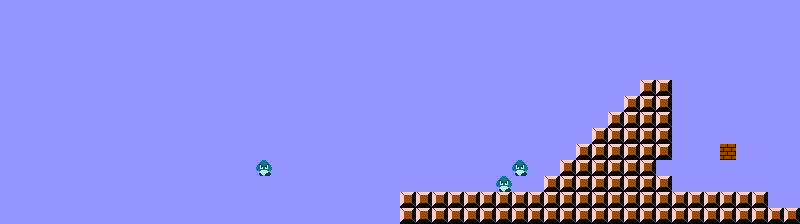

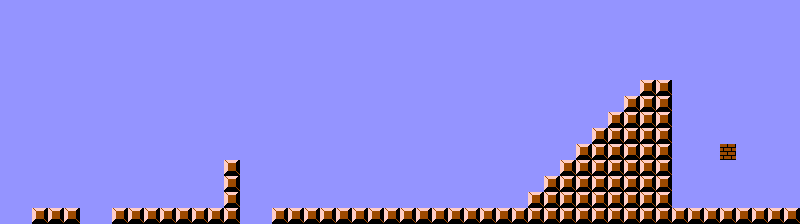

In [20]:
# img1, _, _ = convert_rainbowisland_to_png(fixed_level)
img2, _, _ = convert_mario_to_png(most_similar_for_image)

# Display the image in the notebook
display(img)
display(img2)

In [21]:
copy_level = "------------------------------------------------------------------------------------------------------------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------------------S-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX-----------------S--XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------------------E-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--XXXX"

copy_image_chunked = chunk_string(copy_level, chunk_size=50)
print(copy_image_chunked)

--------------------------------------------------
--------------------------------------------------
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------
------------S-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------S--XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------
------------E-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--XXXX


In [22]:
original_level = "---------------------------------------------------------------------------------------------------------------------XXXXXXXXXXXXXXXXXXXXXXXXXXX-----------------------XXXXXXXXXXXXXXXXXXXXXXXXXXX-----------------------XXXXXXXXXXXXXXXXXXXXXXXXXXX---------------------S-XXXXXXXXXXXXXXXXXXXXXXXXXXX-----------------------XXXXXXXXXXXXXXXXXXXXXXXXXXX-----------------------XXXXXXXXXXXXXXXXXXXXXXXXXXX--------------------S--XXXXXXXXXXXXXXXXXXXXXXXXXXX-----------------------XXXXXXXXXXXXXXXXXXXXXXXXXXX-----------------------XXXXXXXXXXXXXXXXXXXXXXXXXXX---------------------E-XXXXXXXXXXXXXXXXXXXXXXXXXXX-----------------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--XXXX"

original_image_chunked = chunk_string(original_level, chunk_size=50)
print(original_image_chunked)

--------------------------------------------------
--------------------------------------------------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
---------------S-XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
--------------S--XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
---------------E-XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--XXXX


In [23]:
column_analysis = evaluator.column_analysis(
    level_str=original_level,
    reference_str=copy_level,
    analyse_consecutive=True,
    line_size=50,
    progression_type="horizontal"
)

In [29]:
print(column_analysis)
print(column_analysis["matching_ratio"])
print(column_analysis["consecutive_ratio"])

{'total_columns': 50, 'matching_columns': 50, 'matching_ratio': 1.0, 'matching_sequences': ['-------------X', '-------------X', '-------------X', '-------------X', '-------------X', '-------------X', '-------------X', '-------------X', '-------------X', '-------------X', '-------------X', '-------------X', '-------------X', '-------------X', '--------S----X', '-----S-----E-X', '-------------X', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--XXXXXXXXXXXX', '--------------', '--------------', '-------------X', '-------------X', '-------------X', '-------------X'], 'max_co

In [ ]:
print_level_from_columns(column_analysis["matching_sequences"])

--------------------------------------------------
--------------------------------------------------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
---------------S-XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
--------------S--XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
---------------E-XXXXXXXXXXXXXXXXXXXXXXXXXXX------
-----------------XXXXXXXXXXXXXXXXXXXXXXXXXXX------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--XXXX


In [28]:
print_level_from_columns(column_analysis["longest_consecutive_sequence"])

-----------------------------------------
-----------------------------------------
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXX
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXX
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXX
------------S-XXXXXXXXXXXXXXXXXXXXXXXXXXX
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXX
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXX
-----------S--XXXXXXXXXXXXXXXXXXXXXXXXXXX
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXX
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXX
------------E-XXXXXXXXXXXXXXXXXXXXXXXXXXX
--------------XXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
